# Main

In [1]:
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
import numpy as np
import functools as funct
import itertools as itert
import collections as coll

In [2]:
import pandas as pd

,geoCluster,cityId
0,21,1
1,47,1
2,48,1
3,92,1
4,112,1
...,...,...
510,3182,0
511,3183,0
512,3196,0
513,3209,0


In [13]:
import seaborn as sns
from IPython.display import display

In [32]:
from utils import CATEGORIES_TF

## Loading data

In [ ]:
geo = pd.read_csv('geo_params.csv')
geo

In [5]:
sales = pd.read_csv('sales.csv')
sales.head()

,ID,geoCluster,SKU,date,price,sales
0,RR27956459,92,32485,2021-07-05,38.29,4.0
1,RR27956474,92,32549,2021-07-05,89.39,0.5
2,RR27956489,112,32485,2021-05-27,45.39,3.7
3,RR27956490,112,32485,2021-05-28,NaN,NaN
4,RR27956491,112,32485,2021-05-29,NaN,NaN


In [6]:
sales.isna().sum() / sales.shape[0]

ID            0.00000
geoCluster    0.00000
SKU           0.00000
date          0.00000
price         0.83101
sales         0.83101
dtype: float64

In [7]:
sku = pd.read_csv('sku.csv')
sku.head()

,SKU,Category,Type,brandId,lagerUnitQuantity,Units,trademark,countryOfOrigin,Group
0,24,Pomegranate,Tropical fruit — Pomegranate— Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits
1,208,"Water, sparkling",Therapeutic-table water — PET — from 1 to 2 L,1241.0,1.5,NaN,3670.0,1.0,Mineral water
2,1008,"Water, import, sparkling",Therapeutic-table water — Import — Glass,1241.0,0.5,NaN,4970.0,14.0,Mineral water
3,16649,"Water, still",Table water — PET — from 1 to 2 L — Still,1241.0,1.5,NaN,1323.0,1.0,Mineral water
4,20872,"Water, sparkling",Therapeutic-table water — PET — from 1 to 2 L,2693.0,1.5,NaN,4384.0,1.0,Mineral water


# Merge

Merge on sku and geoClusters. IT contains all the data in a single DF. We onlu use Group from SKU nevertheless.

In [8]:
merge = sales.merge(sku, how='inner', left_on='SKU', right_on='SKU')
merge = merge.merge(geo, how='inner', left_on='geoCluster', right_on='geoCluster')
merge

,ID,geoCluster,SKU,date,price,sales,Category,Type,brandId,lagerUnitQuantity,Units,trademark,countryOfOrigin,Group,cityId
0,RR27956459,92,32485,2021-07-05,38.29,4.0,Banana,Banana — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,1
1,RR27956474,92,32549,2021-07-05,89.39,0.5,Grapefruit,Citrus fruit — Grapefruit — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,1
2,RR42800188,92,16649,2021-06-05,17.69,1.0,"Water, still",Table water — PET — from 1 to 2 L — Still,1241.0,1.5,NaN,1323.0,1.0,Mineral water,1
3,RR42800189,92,16649,2021-06-06,NaN,NaN,"Water, still",Table water — PET — from 1 to 2 L — Still,1241.0,1.5,NaN,1323.0,1.0,Mineral water,1
4,RR42800190,92,16649,2021-06-07,NaN,NaN,"Water, still",Table water — PET — from 1 to 2 L — Still,1241.0,1.5,NaN,1323.0,1.0,Mineral water,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4605980,RR50600743,162,503007,2021-07-01,NaN,NaN,"Plain rye-wheat bread, parbaking",Bread — plain — rye-wheat,8274.0,340.0,NaN,NaN,1.0,Bakery,1
4605981,RR50600744,162,503007,2021-07-02,NaN,NaN,"Plain rye-wheat bread, parbaking",Bread — plain — rye-wheat,8274.0,340.0,NaN,NaN,1.0,Bakery,1
4605982,RR50600745,162,503007,2021-07-03,NaN,NaN,"Plain rye-wheat bread, parbaking",Bread — plain — rye-wheat,8274.0,340.0,NaN,NaN,1.0,Bakery,1
4605983,RR50600746,162,503007,2021-07-04,NaN,NaN,"Plain rye-wheat bread, parbaking",Bread — plain — rye-wheat,8274.0,340.0,NaN,NaN,1.0,Bakery,1


In [9]:
merge = merge[~merge['sales'].isna()]
merge.head()

,ID,geoCluster,SKU,date,price,sales,Category,Type,brandId,lagerUnitQuantity,Units,trademark,countryOfOrigin,Group,cityId
0,RR27956459,92,32485,2021-07-05,38.29,4.0,Banana,Banana — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,1
1,RR27956474,92,32549,2021-07-05,89.39,0.5,Grapefruit,Citrus fruit — Grapefruit — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,1
2,RR42800188,92,16649,2021-06-05,17.69,1.0,"Water, still",Table water — PET — from 1 to 2 L — Still,1241.0,1.5,NaN,1323.0,1.0,Mineral water,1
33,RR42800233,92,440815,2021-07-02,45.79,2.0,"Water, still",Table water — PET — more than 3 L,1330.0,6.0,NaN,2781.0,1.0,Mineral water,1
36,RR42800236,92,440815,2021-07-05,45.79,1.0,"Water, still",Table water — PET — more than 3 L,1330.0,6.0,NaN,2781.0,1.0,Mineral water,1


In [10]:
merge['date'] = pd.to_datetime(merge.date).copy()

/tmp/ipykernel_84578/2336709110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge['date'] = pd.to_datetime(merge.date).copy()


In [11]:
merge

,ID,geoCluster,SKU,date,price,sales,Category,Type,brandId,lagerUnitQuantity,Units,trademark,countryOfOrigin,Group,cityId
0,RR27956459,92,32485,2021-07-05,38.29,4.0,Banana,Banana — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,1
1,RR27956474,92,32549,2021-07-05,89.39,0.5,Grapefruit,Citrus fruit — Grapefruit — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,1
2,RR42800188,92,16649,2021-06-05,17.69,1.0,"Water, still",Table water — PET — from 1 to 2 L — Still,1241.0,1.5,NaN,1323.0,1.0,Mineral water,1
33,RR42800233,92,440815,2021-07-02,45.79,2.0,"Water, still",Table water — PET — more than 3 L,1330.0,6.0,NaN,2781.0,1.0,Mineral water,1
36,RR42800236,92,440815,2021-07-05,45.79,1.0,"Water, still",Table water — PET — more than 3 L,1330.0,6.0,NaN,2781.0,1.0,Mineral water,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4604927,RR55832871,2963,437495,2020-11-29,19.99,4.0,"Plain croissant, parbaking",Croissant,8314.0,50.0,NaN,9666.0,6.0,Bakery,0
4605146,RR42809513,1315,20872,2021-06-08,34.89,2.0,"Water, sparkling",Therapeutic-table water — PET — from 1 to 2 L,2693.0,1.5,NaN,4384.0,1.0,Mineral water,0
4605174,RR42815378,1790,233272,2020-12-23,29.09,4.0,"Water, import, sparkling",Therapeutic-table water — Import — PET,2737.0,1.0,NaN,1839.0,14.0,Mineral water,0
4605921,RR50628992,1629,690818,2021-05-15,25.49,4.0,"Ciabatta, light, plain, parbaking",Ciabatta,8274.0,250.0,NaN,4043.0,NaN,Bakery,0


In [12]:
len(merge['Group'].unique())

5

# Fourirer

<AxesSubplot:xlabel='date', ylabel='sales'>

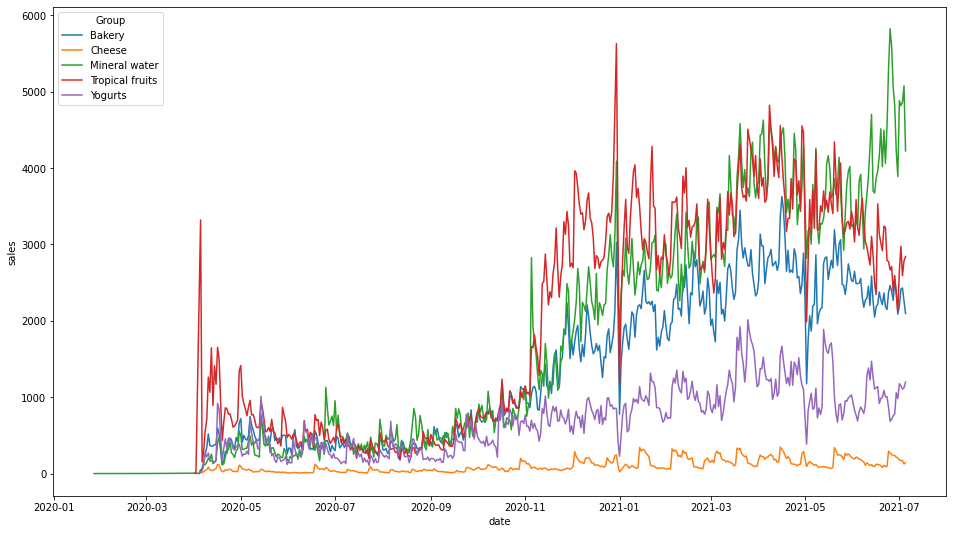

Timedelta('460 days 00:00:00')

Timedelta('525 days 00:00:00')

Timedelta('457 days 00:00:00')

Timedelta('457 days 00:00:00')

Timedelta('457 days 00:00:00')

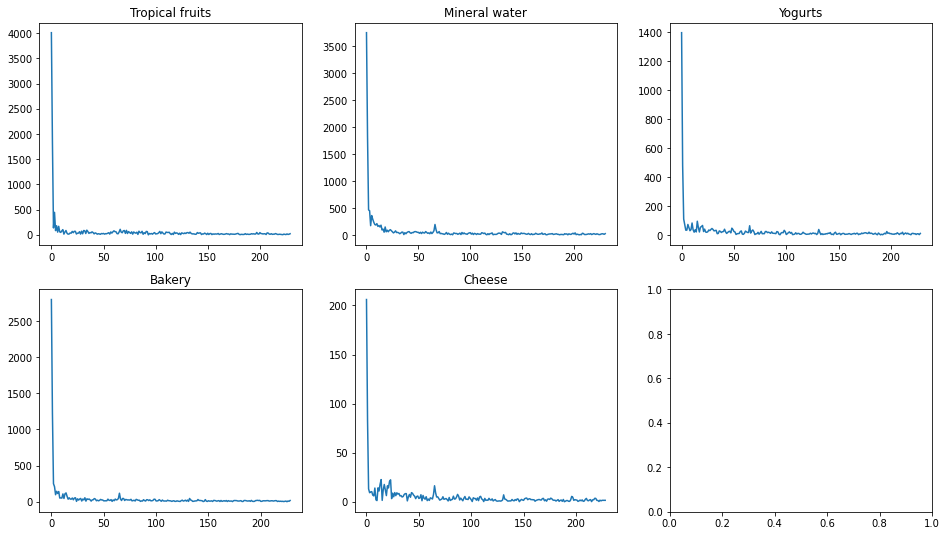

In [14]:
def get_groups(df):
    df = df.groupby(by=['Group', 'date']).sum()
    return df

groups = merge['Group'].unique()
df= get_groups(merge)
fig = plt.figure(figsize=(16, 9))
display(sns.lineplot(data=df, x='date', y='sales', hue='Group'))
plt.show()
fig, axes = plt.subplots(2,3, figsize=(16, 9))
axes = list(axes[0]) + list(axes[1])
for ax, g in zip(axes, groups):
    df_group = df.loc[g]
    sales = df_group['sales']
    timedelta = df_group.index.max() - df_group.index.min()
    display(timedelta)
    N = sales.shape[0]
    yf = fft(np.array(sales))
    xf = fftfreq(N, 1/N)[:N//2]
    sns.lineplot(x=xf, y=2.0/N * np.abs(yf[0:N//2]), ax=ax)
    ax.set_title(g)


<AxesSubplot:xlabel='date', ylabel='sales'>

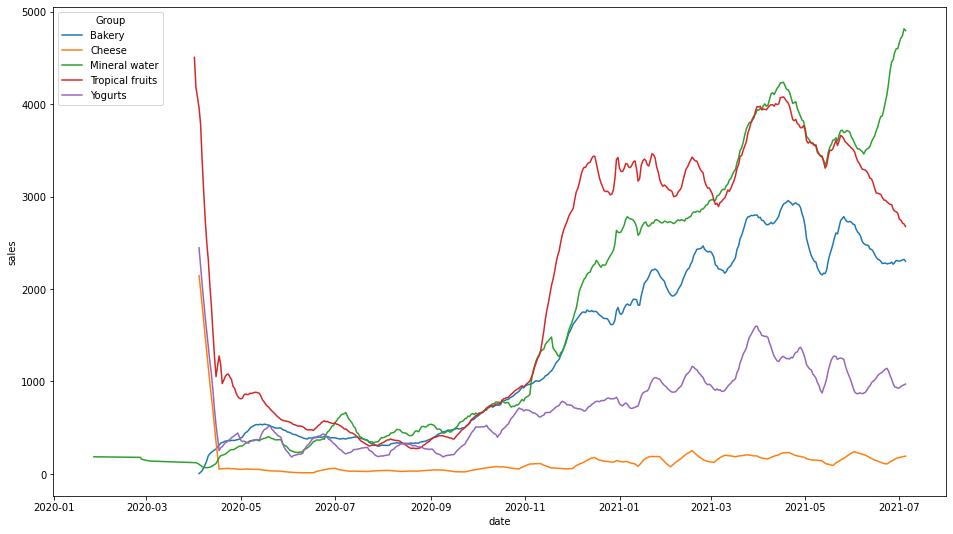

In [15]:
plt.figure(figsize=(16, 9))
display(sns.lineplot(data=df.rolling(14, min_periods=1).mean(), x='date', y='sales', hue='Group'))

In [16]:
x_fields = ['price']
y_field = ['sales']
df = get_groups(merge)
df = df[x_fields + y_field]
df.describe()

,price,sales
count,2297.000000,2297.000000
mean,22870.021720,1217.784541
std,24026.310011,1265.606559
min,18.490000,1.000000
25%,5890.490000,253.000000
50%,14456.170000,660.300000
75%,29875.400000,2206.900000
max,126219.650000,5821.000000


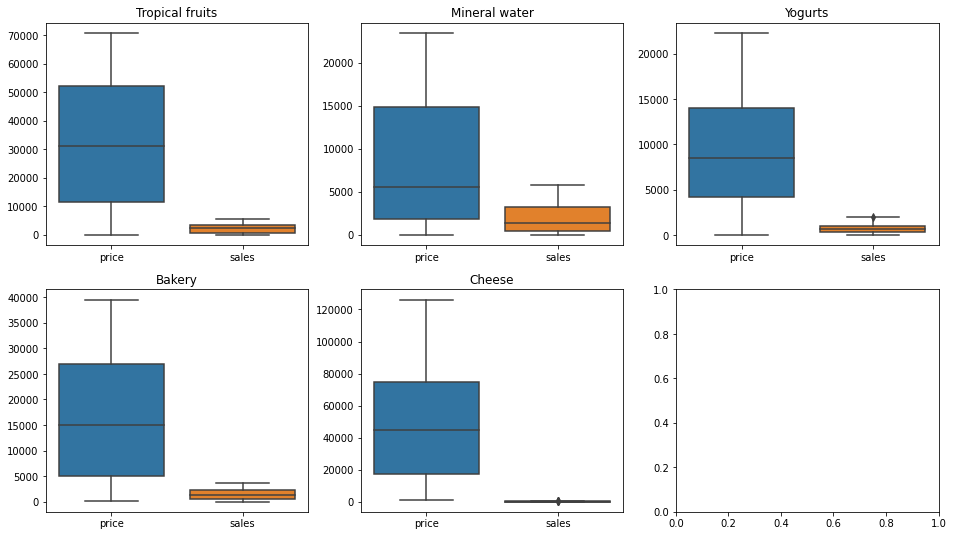

In [17]:
def ho_plot_group(df, func):
    fig, axes = plt.subplots(2,3, figsize=(16, 9))
    axes = list(axes[0]) + list(axes[1])
    for ax, g in zip(axes, groups):
        df_tmp = df.loc[g]
        func(df_tmp, ax)
        ax.set_title(g)

ho_plot_group(df, lambda x, ax: sns.boxplot(data=x, ax=ax))

# ARIMA

In [18]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA, ARIMAResultsWrapper
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/sergi/hackupc/makauly-kulkin/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sergi/hackupc/makauly-kulkin/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sergi/hackupc/makauly-kulkin/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sergi/hackupc/makauly-kulkin/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters 

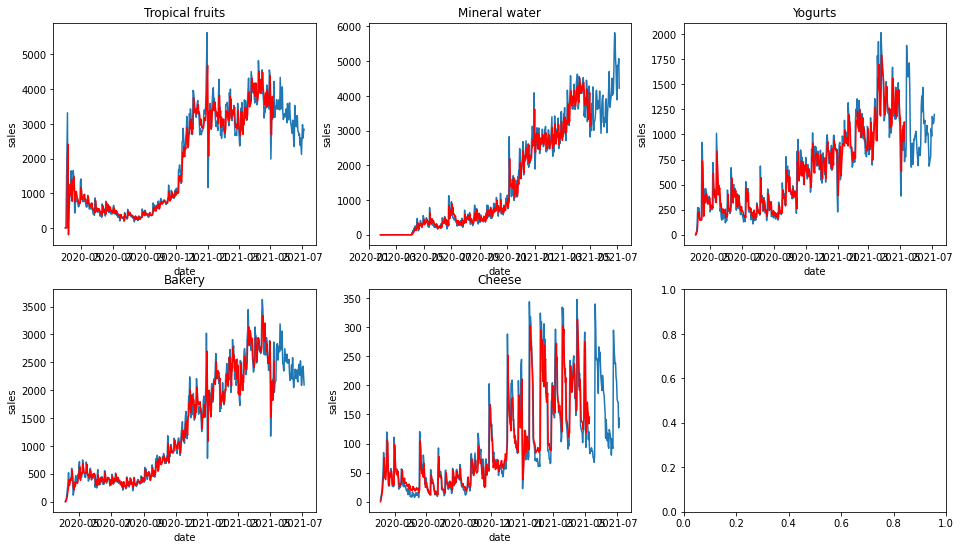

In [20]:
def arima_plot(df, ax):
    sns.lineplot(data=df, x='date', y='sales', ax=ax)
    model = ARIMA(df['sales'], order=(2,1,2))
    model_fit = model.fit()
    res = model_fit.predict(start=0, end=400)
    ax.plot(res, color="red")
ho_plot_group(df,arima_plot)

In [23]:
skip = True

In [24]:
if not skip:
    merge.groupby(by='Category').agg(['value_counts'])


In [26]:
merge.groupby(by='countryOfOrigin').sum()


,geoCluster,SKU,price,sales,brandId,lagerUnitQuantity,Units,trademark,cityId
countryOfOrigin,,,,,,,,,
1.0,622354281,69986077505,12572165.53,1144948.416,383790371.0,39114111.5,0.0,2.008141e+09,102
6.0,40550410,8840715199,2897992.01,50261.200,100201418.0,464578.0,0.0,1.666705e+08,0
14.0,72800265,8383929802,1188563.71,146407.000,51235892.0,23059.5,0.0,1.406424e+08,32
16.0,71018887,7841827594,9945841.43,21906.562,87389673.0,31929.0,0.0,1.801767e+08,0
33.0,38114460,9758202426,5614182.39,11160.471,46753434.0,17082.0,0.0,1.771403e+07,0
37.0,16723625,717173703,500361.40,16181.347,0.0,7461.0,0.0,0.000000e+00,0


In [27]:
merge.isna().sum() / merge.shape[0]

ID                   0.000000
geoCluster           0.000000
SKU                  0.000000
date                 0.000000
price                0.000000
sales                0.000000
Category             0.073671
Type                 0.073671
brandId              0.514366
lagerUnitQuantity    0.000000
Units                1.000000
trademark            0.286149
countryOfOrigin      0.504371
Group                0.000000
cityId               0.000000
dtype: float64

In [28]:
merge.describe()

,geoCluster,SKU,price,sales,brandId,lagerUnitQuantity,Units,trademark,countryOfOrigin,cityId
count,778366.000000,778366.000000,778366.000000,778366.000000,378001.000000,778366.000000,0.0,555637.000000,385781.000000,778366.000000
mean,2230.150161,317638.404835,67.490666,3.593748,3423.112767,106.980870,NaN,6765.173066,5.692268,0.000403
std,268.903113,295495.118795,85.631611,4.627158,2615.824102,158.334996,NaN,4726.933397,9.084592,0.034265
min,92.000000,24.000000,0.000000,0.001000,967.000000,0.500000,NaN,297.000000,1.000000,0.000000
25%,2041.000000,32546.000000,24.190000,1.000000,1241.000000,1.000000,NaN,1921.000000,1.000000,0.000000
50%,2129.000000,219149.000000,38.490000,2.500000,2737.000000,1.500000,NaN,6133.000000,1.000000,0.000000
75%,2279.000000,591899.000000,61.890000,4.000000,3784.000000,300.000000,NaN,9666.000000,6.000000,0.000000
max,3230.000000,838137.000000,7246.890000,801.000000,8314.000000,550.000000,NaN,15156.000000,37.000000,25.000000


In [29]:
merge.sort_values('sales')

,ID,geoCluster,SKU,date,price,sales,Category,Type,brandId,lagerUnitQuantity,Units,trademark,countryOfOrigin,Group,cityId
1903856,RR29377093,2121,96123,2021-01-16,113.69,0.001,Grapefruit,Citrus fruit — Grapefruit — Graded,NaN,1.0,NaN,NaN,37.0,Tropical fruits,0
2907830,RR30022058,2234,32546,2021-01-16,0.00,0.001,Orange,Citrus fruit — Orange — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,0
2906061,RR30020924,2234,32485,2021-01-16,42.69,0.001,Banana,Banana — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,0
1892724,RR48114265,2120,642700,2021-01-16,6049.29,0.001,Semi-hard coarse-pored cheese,semi-hard cheese — More expensive — National —...,2737.0,1.0,NaN,11960.0,16.0,Cheese,0
2244061,RR29595263,2153,32549,2021-01-16,0.00,0.001,Grapefruit,Citrus fruit — Grapefruit — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1796365,RR29301896,2115,32485,2021-01-13,36.99,302.000,Banana,Banana — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,0
1774934,RR29287462,2114,32485,2021-01-11,36.99,309.400,Banana,Banana — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,0
2511533,RR44682816,2189,39465,2020-11-05,16.09,421.000,"Water, slightly sparkling",Table water — PET — from 1 to 2 L — Slightly s...,1241.0,1.5,NaN,1323.0,1.0,Mineral water,0
2510657,RR44679870,2189,16649,2020-11-05,16.09,489.000,"Water, still",Table water — PET — from 1 to 2 L — Still,1241.0,1.5,NaN,1323.0,1.0,Mineral water,0


In [30]:
flat_map = lambda f, xs: sum(map(f, xs), [])

In [31]:
flat_map(lambda x: x, [[2,3], [4,3]])

[2, 3, 4, 3]

# Test

In [40]:
pd.read_csv('test.csv')

,ID,geoCluster,SKU,date,price_filled,sales
0,RR27956447,21,32485,2021-07-08,39.69,NaN
1,RR27956448,21,32485,2021-07-09,39.69,NaN
2,RR27956449,21,32485,2021-07-10,39.69,NaN
3,RR27956450,21,32485,2021-07-11,39.69,NaN
4,RR27956451,21,32485,2021-07-12,39.69,NaN
...,...,...,...,...,...,...
202732,RR55912539,3230,711838,2021-07-15,28.49,NaN
202733,RR55912540,3230,711838,2021-07-16,28.49,NaN
202734,RR55912541,3230,711838,2021-07-17,28.49,NaN
202735,RR55912542,3230,711838,2021-07-18,28.49,NaN
